In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/Users/ira/Downloads/diplom/REALEC_Inspector')

import sqlite3
from tqdm import tqdm_notebook as tqdm
import os
import numpy as np
import pandas as pd
import collections
import statistics
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.tokenize import word_tokenize
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold

SEED = 23

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('/Users/ira/Downloads/REALEC_Inspector/data/feature_result.csv')
df.head(3)

,av_depth,max_depth,min_depth,num_acl,num_rel_cl,num_advcl,num_sent,num_tok,av_tok_before_root,av_len_sent,...,num_misspelled_tokens,punct_mistakes_pp,punct_mistakes_because,punct_mistakes_but,punct_mistakes_compare,million_mistake,side_mistake,name,text,target
0,3.555556,6,2,2,0,1,18,244,4.388889,13.555556,...,2,0,0,0,0,0,0,./data/exam/exam2017/OBy_146_1,This two line graphs illustrates monthly avera...,60
1,5.428571,10,4,1,3,1,7,175,6.285714,25.000000,...,3,0,0,0,0,0,0,./data/exam/exam2017/EGe_15_1,"﻿We have two graphics, which show us the popul...",65
2,3.812500,6,0,5,0,13,16,292,4.562500,18.250000,...,1,0,0,1,0,0,0,./data/exam/exam2017/DOv_2_2,More and more young people are stunding on the...,60


In [3]:
df.shape

(3442, 75)

# Classification

In [4]:
feature_columns = list(df.columns)
feature_columns.remove('target')
feature_columns.remove('name')
feature_columns.remove('text')
feature_columns = feature_columns

In [5]:
feature_columns

['av_depth',
 'max_depth',
 'min_depth',
 'num_acl',
 'num_rel_cl',
 'num_advcl',
 'num_sent',
 'num_tok',
 'av_tok_before_root',
 'av_len_sent',
 'num_cl',
 'num_tu',
 'num_compl_tu',
 'num_coord',
 'num_poss',
 'num_prep',
 'num_adj_noun',
 'num_part_noun',
 'num_noun_inf',
 'pos_sim_nei',
 'pos_sim_all',
 'lemma_sim_all',
 'lemma_sim_nei',
 'density',
 'ls',
 'vs',
 'corrected_vs',
 'squared_vs',
 'lfp_1000',
 'lfp_2000',
 'lfp_uwl',
 'lfp_rest',
 'ndw',
 'ttr',
 'corrected_ttr',
 'root_ttr',
 'log_ttr',
 'uber_ttr',
 'd',
 'lv',
 'vvi',
 'squared_vv',
 'corrected_vv',
 'vvii',
 'nv',
 'adjv',
 'advv',
 'modv',
 'der_level3',
 'der_level4',
 'der_level5',
 'der_level6',
 'mci',
 'freq_finite_forms',
 'freq_aux',
 'num_inf',
 'num_gerunds',
 'num_pres_sing',
 'num_pres_plur',
 'num_past_part',
 'num_past_simple',
 'num_linkings',
 'num_4grams',
 'num_func_ngrams',
 'num_shell_noun',
 'num_misspelled_tokens',
 'punct_mistakes_pp',
 'punct_mistakes_because',
 'punct_mistakes_but',
 'pu

In [6]:
def tokenizer(text):
    return word_tokenize(text)

In [7]:
# tokenizer('I am Ira')

In [8]:
# tfidf = TfidfVectorizer(lowercase=True, tokenizer=tokenizer)
X = df[feature_columns]
targets = []
for t in df['target']:
    if int(t) >= 70:
        targets.append('best')
#     elif int(t) < 60:
#         targets.append('worst')
    else:
        targets.append('worst')
y = targets

counter=collections.Counter(y)
print(counter)

Counter({'worst': 3058, 'best': 384})


In [9]:
# feature_columns

In [10]:
get_numeric_data = FunctionTransformer(lambda x: x[feature_columns], validate=False)

model = Pipeline([
    ('features', FeatureUnion([
        ('numeric_features', Pipeline([
            ('selector', get_numeric_data)
        ]))
    ])),
    ('clf', LogisticRegression(class_weight='balanced', random_state=SEED))
])

In [11]:
def cross_val(X, y, model, kf):
    y = np.array(y)
    X = np.array(X)
    
    dicts = []
    
    for train_index, test_index in tqdm(kf.split(X, y)):

        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        X_train = pd.DataFrame(data=X_train[0:,0:],
                               columns=[feature_columns])
        X_test = pd.DataFrame(data=X_test[0:,0:],
                               columns=[feature_columns])

        X_train[feature_columns] = X_train[feature_columns].apply(pd.to_numeric)
        X_test[feature_columns] = X_test[feature_columns].apply(pd.to_numeric)
        
        
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        report = classification_report(y_test, y_pred, output_dict=True)
        dicts.append(report)
    
    return dicts

In [12]:
kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=SEED)
dicts = cross_val(X, y, model, kf)

In [13]:
classes = ['best', 'worst',
           'micro avg', 'macro avg', 'weighted avg']

In [14]:
result = {
    'precision': [],
    'recall': [], 
    'f1-score': []
}

for cl in classes:
    precision = []
    recall = []
    f1_score = []
    support = []
    for d in dicts:
        precision.append(d[cl]['precision'])
        recall.append(d[cl]['recall'])
        f1_score.append(d[cl]['f1-score'])
    result['precision'].append(round(statistics.mean(precision), 3))
    result['recall'].append(round(statistics.mean(recall), 3))
    result['f1-score'].append(round(statistics.mean(f1_score),3))
result = pd.DataFrame(data=result, index=classes)
result

,precision,recall,f1-score
best,0.242,0.693,0.359
worst,0.950,0.728,0.824
micro avg,0.724,0.724,0.724
macro avg,0.596,0.710,0.591
weighted avg,0.871,0.724,0.772


# Feature importance

### 1. Boruta

In [15]:
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy

In [16]:
y = np.array(y)
X = np.array(X)
y = y.ravel()

In [17]:
# rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)
# feat_selector = BorutaPy(rf, n_estimators='auto', verbose=0, random_state=SEED)
# feat_selector.fit(X, y)

In [18]:
# for i, feature in enumerate(feat_selector.support_):
#     if feature == True:
#         print(feature_columns[i])

### 2. Simple feature importances

In [19]:
df = df.drop(['name', 'target', 'text'], axis=1)

In [20]:
df['target'] = targets

In [21]:
from sklearn.model_selection import train_test_split

In [22]:
X = df.drop('target',axis=1)
y = df['target']
df = pd.DataFrame(X, columns=X.columns)

#df['diagnosis'] = cancer.target
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.15)

cl = RandomForestClassifier(n_estimators=500, oob_score=True)
cl.fit(X_train, y_train)
print(cl.oob_score_)
print( cl.score(X_test, y_test) )

0.8895726495726496
0.9013539651837524


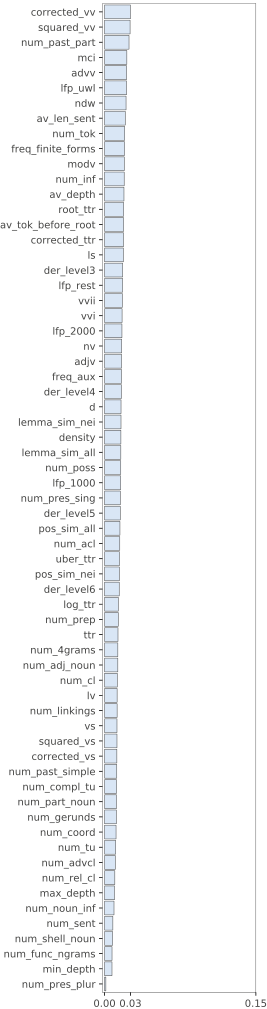

In [25]:
I = pd.DataFrame()

I['Feature'] = X_train.columns
I['Importance'] = cl.feature_importances_
I = I.sort_values('Importance', ascending=False)
I = I.set_index('Feature')
viz = plot_importances(I,
#                 width=6,
#                 color='#FDDB7D',
#                 bgcolor='#F1F8FE',
#                 title="Feature importance via average gini/variance drop (sklearn)"
                       title=None
                      )
viz

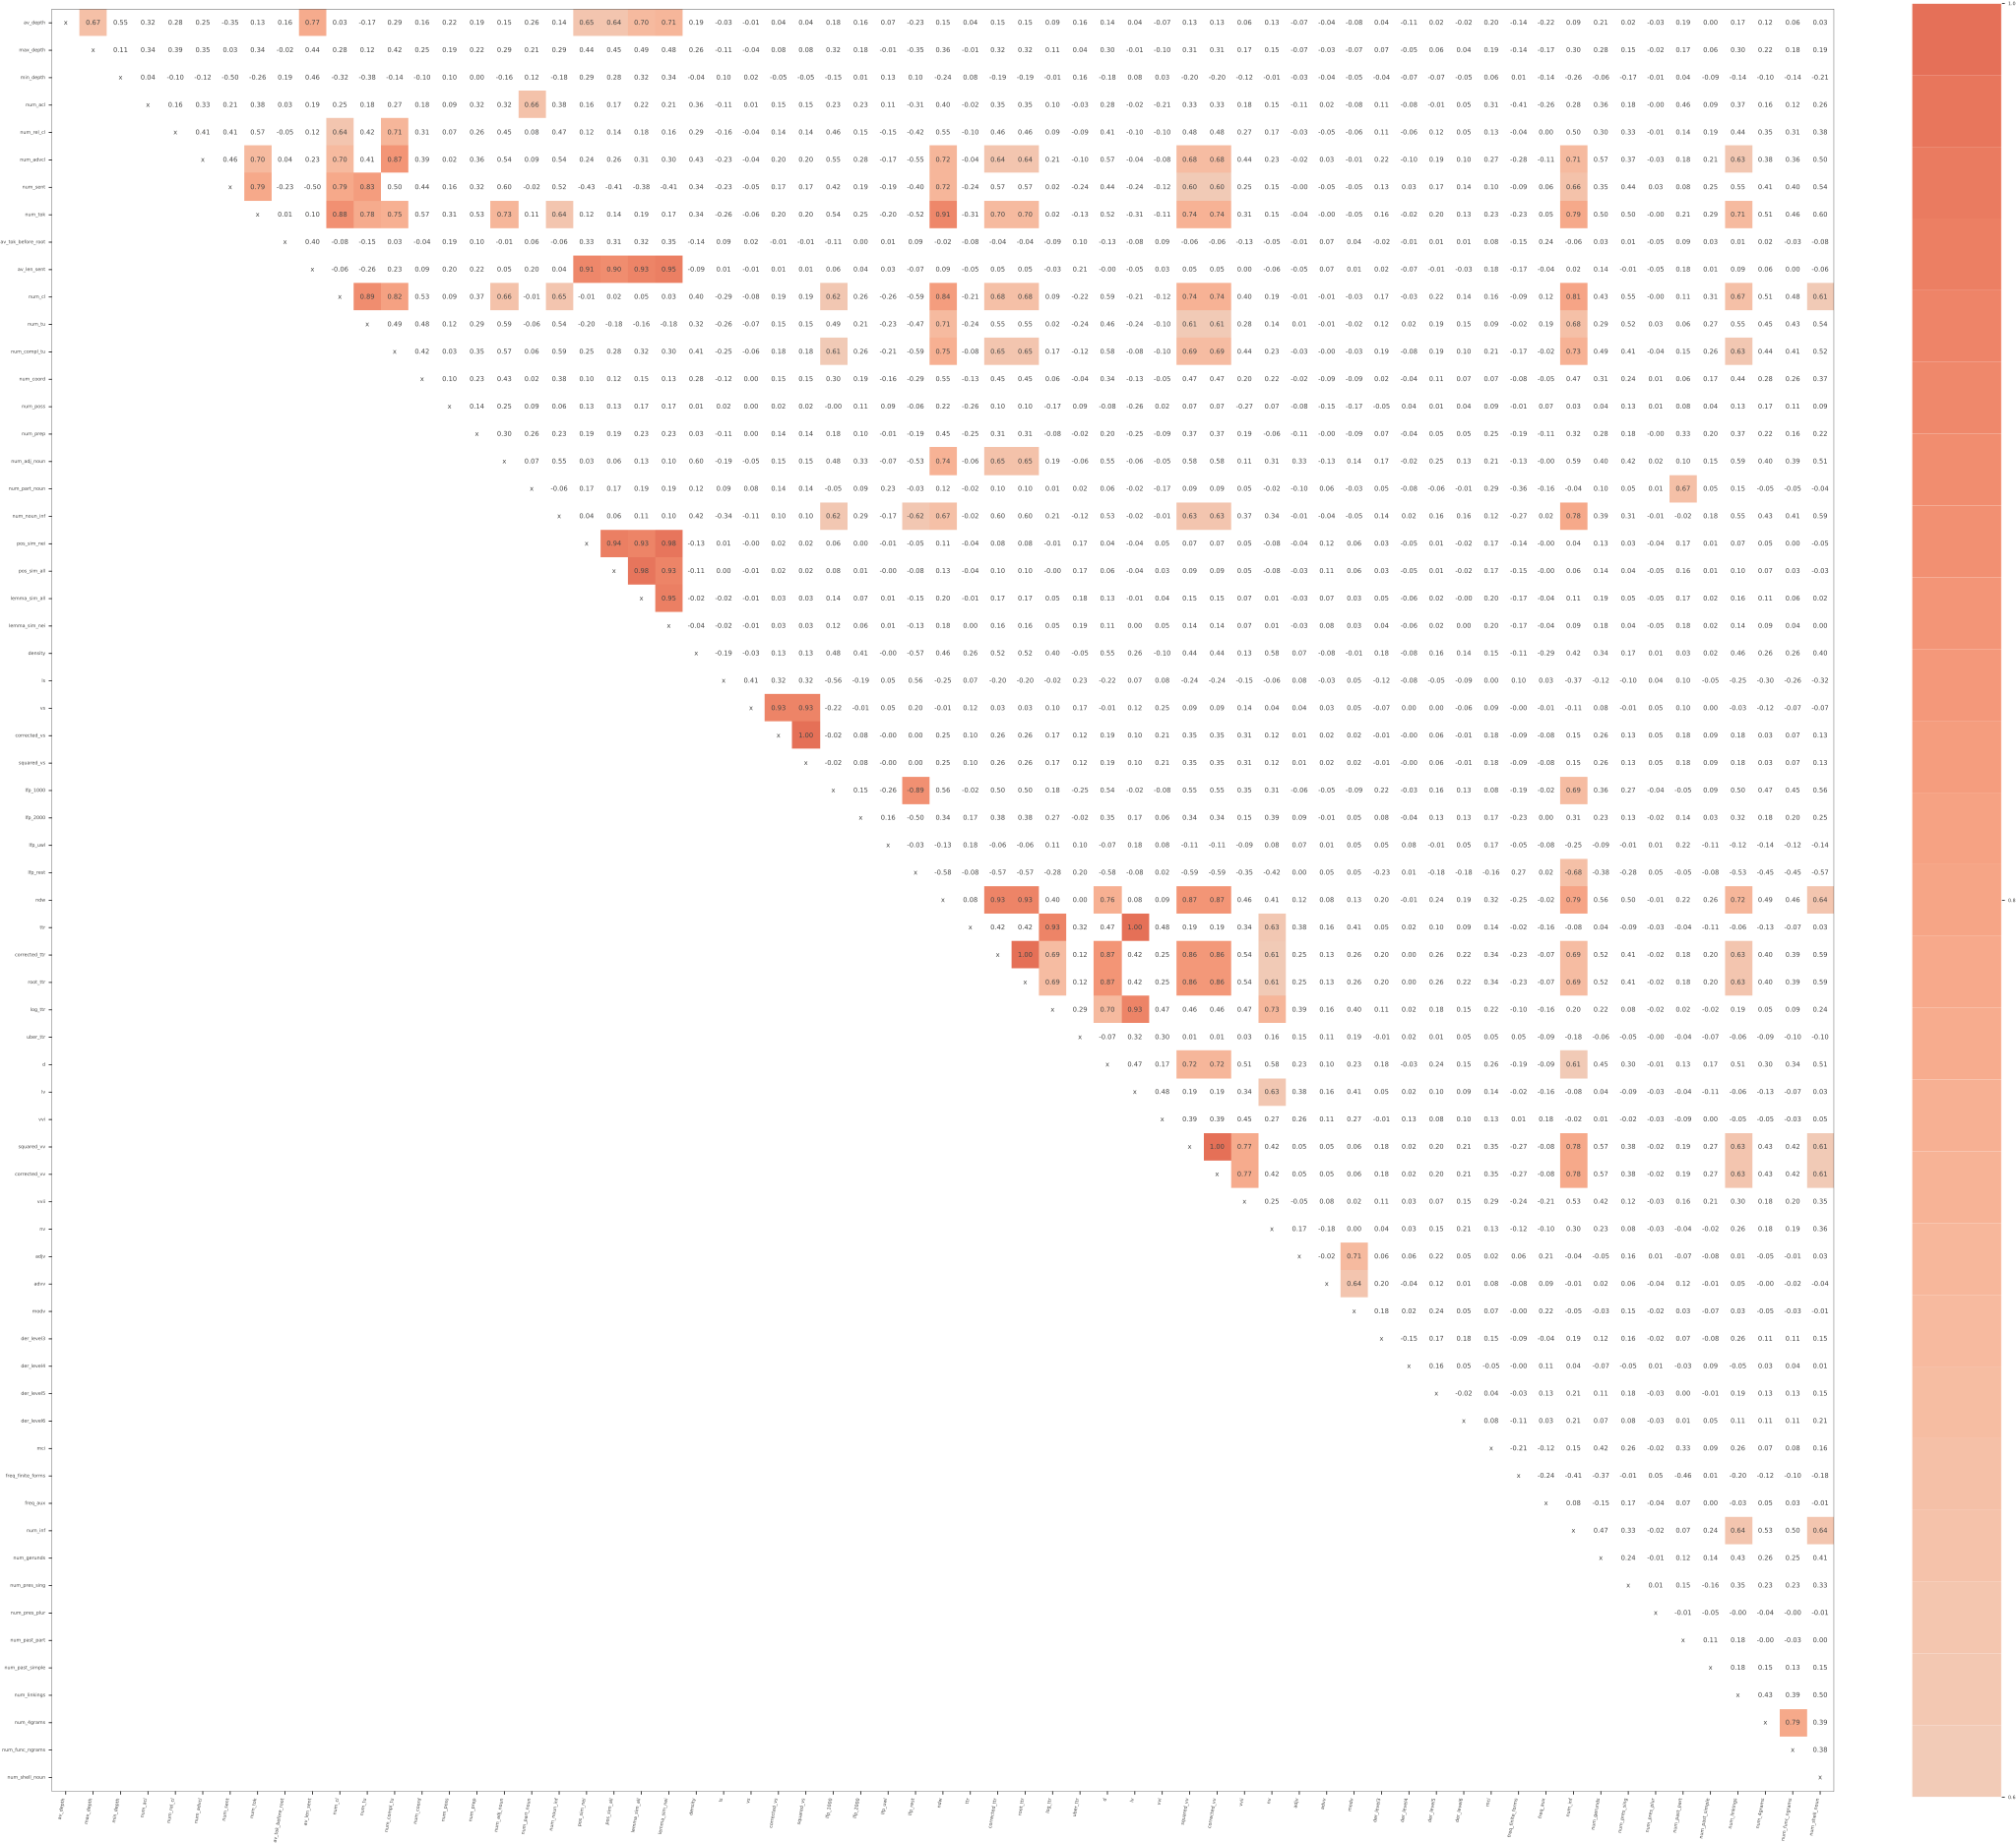

In [26]:
viz = plot_corr_heatmap(X_train, figsize=(30,30), label_fontsize=5, value_fontsize=7)
viz.save('depend.svg')
viz

### 2. Beware Default Random Forest Importances

In [35]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_error
from sklearn.model_selection import cross_val_score
from rfpimp import *
from sklearn.model_selection import train_test_split
from sklearn.base import clone

In [39]:
df_all = df

num_features = feature_columns
target = 'target'

df = df_all[num_features + [target]]
df_train, df_test = train_test_split(df, test_size=0.15)

In [40]:
X_train, y_train = df_train.drop('target',axis=1), df_train['target']
X_test, y_test = df_test.drop('target',axis=1), df_test['target']

rf = RandomForestClassifier(n_estimators=100, n_jobs=-1,
                            max_features=1.0,
                            min_samples_leaf=10, oob_score=True)
rf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features=1.0, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

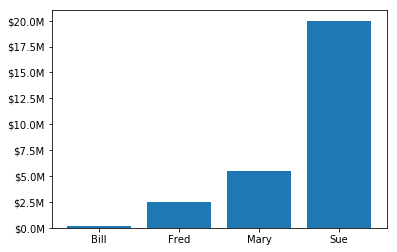

In [51]:
k = I.sort_values(by=['Importance'], ascending=False).head(11)

In [52]:
k

,Importance
Feature,
corrected_vv,0.025696
squared_vv,0.025328
num_past_part,0.024273
mci,0.022117
advv,0.021936
lfp_uwl,0.021824
ndw,0.021325
av_len_sent,0.020530
num_tok,0.020031


In [57]:
k.columns

Index(['Importance'], dtype='object')

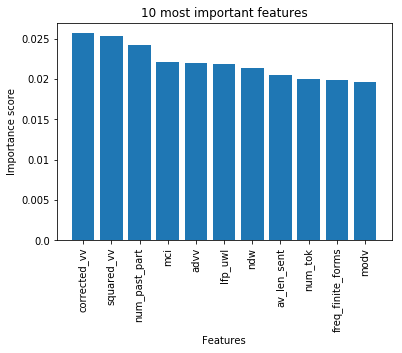

In [62]:
from matplotlib.ticker import FuncFormatter
import matplotlib.pyplot as plt
import numpy as np

x = np.arange(11)
money = k['Importance'].tolist()


def millions(x, pos):
    'The two args are the value and tick position'
    return x


formatter = FuncFormatter(millions)

fig, ax = plt.subplots()
ax.yaxis.set_major_formatter(formatter)
plt.bar(x, money)
plt.ylabel('Importance score')
plt.xlabel('Features')
plt.title('10 most important features')
plt.xticks(x, ['corrected_vv', 'squared_vv', 'num_past_part',
               'mci' ,'advv', 'lfp_uwl', 'ndw', 'av_len_sent',
               'num_tok', 'freq_finite_forms', 'modv'])
plt.xticks(rotation=90)
#plt.show()
plt.savefig('importance.png')

In [63]:
import seaborn as sns

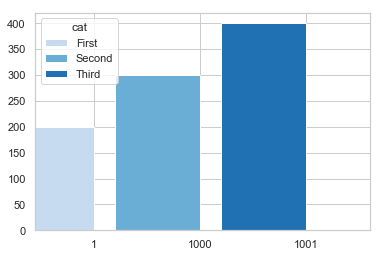

In [68]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

x=[1,1000,1001]
y=[200,300,400]
sns.set_context(rc={"figure.figsize": (8, 4)})
nd = np.arange(3)
width=0.8
plt.xticks(nd+width/2., ('1','1000','1001'))
plt.xlim(-0.15,3)
fig = plt.bar(nd, y, color=sns.color_palette("Blues",3))
plt.legend(fig, ['First','Second','Third'], loc = "upper left", title = "cat")
plt.show()

In [67]:
ax = sns.barplot(x="Features", y="Importance score",
                 data=k['Importance'].tolist(),
                 order=['corrected_vv', 'squared_vv', 'num_past_part',
                        'mci' ,'advv', 'lfp_uwl', 'ndw', 'av_len_sent',
                        'num_tok', 'freq_finite_forms', 'modv'])

AttributeError: 'list' object has no attribute 'get'

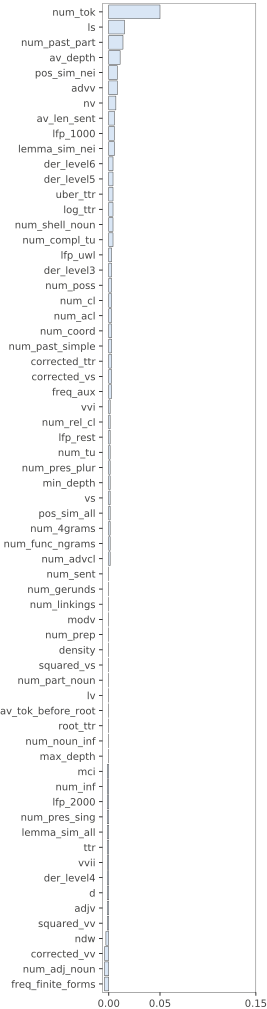

In [70]:
I = importances(rf, X_test, y_test)
viz = plot_importances(I)
viz

In [71]:
features = [["av_depth", "max_depth",
 "min_depth", "num_acl",
 "num_rel_cl", "num_advcl", "num_sent",
 "num_tok", "av_tok_before_root", "av_len_sent",
 "num_cl", "num_tu", "num_compl_tu", "num_coord",
 "num_poss", "num_prep", "num_adj_noun",
 "num_part_noun", "num_noun_inf", "pos_sim_nei",
 "pos_sim_all", "lemma_sim_all", "lemma_sim_nei"], 
            ["density", "ls", "vs", "corrected_vs", "squared_vs",
 "lfp_1000", "lfp_2000", "lfp_uwl", "lfp_rest", "ndw",
 "ttr", "corrected_ttr", "root_ttr", "log_ttr",
 "uber_ttr", "d", "lv", "vvi", "squared_vv", "corrected_vv",
 "vvii", "nv", "adjv", "advv", "modv"], 
            ["der_level3", "der_level4", "der_level5",
 "der_level6", "mci", "freq_finite_forms", "freq_aux",
 "num_inf", "num_gerunds", "num_pres_sing",
 "num_pres_plur", "num_past_part", "num_past_simple"], ["num_linkings", "num_4grams", "num_func_ngrams", "num_shell_noun"]]

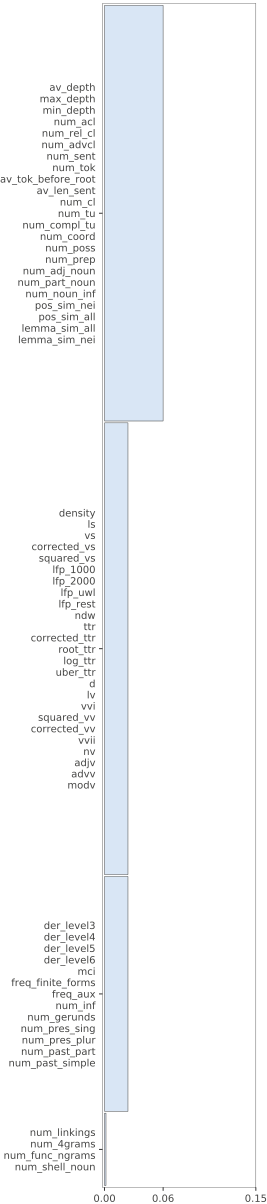

In [73]:
I = importances(rf, X_test, y_test, features=features)
viz = plot_importances(I, vscale=1.3)
viz